In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

C:\Users\32827\AppData\Local\Temp\ipykernel_3924\1346328363.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


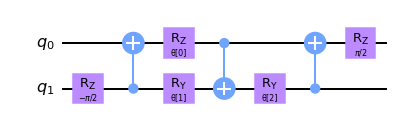

In [2]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

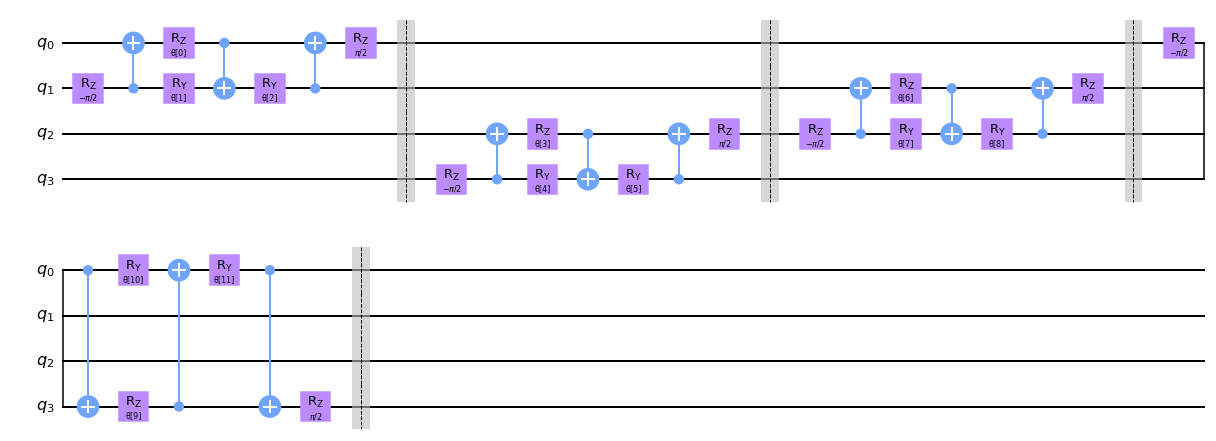

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

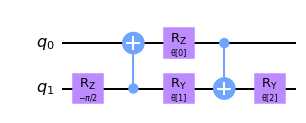

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

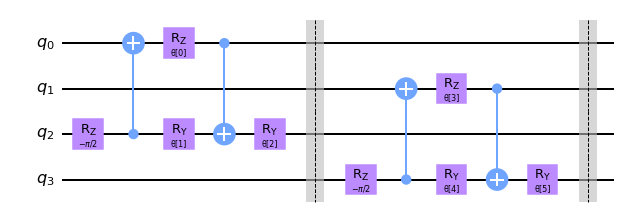

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

# QNN network on test bit data

In [6]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [7]:
from numpy import random

In [8]:
images, labels = generate_dataset(500)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)
select = random.randint(len(train_images),size=100)
print(select)
for x in select:
    if train_labels[x] == -1:
        train_images[x][7] = 1.57
        train_labels[x] = 1



[305 116  28  33 313   9  21 128 110 330  64 294  45  74 338 195  42 190
 270 173 218 235 209 292 165 172 118  85 147 344 252 198 348  68  37  80
 115  42  66  93 103 158 269 318  21 203  56  79  18  87 327 146 306  82
 248  38  75 304  17 343  65 101 177 343 295 276 245 231 155 190 325 228
 314 252 196  48 136 320 247 193 208 234 289 220 309 258 256 187  89 145
 116 120 340 198  84 174 216 346 335 117]


1
-1
-1
-1


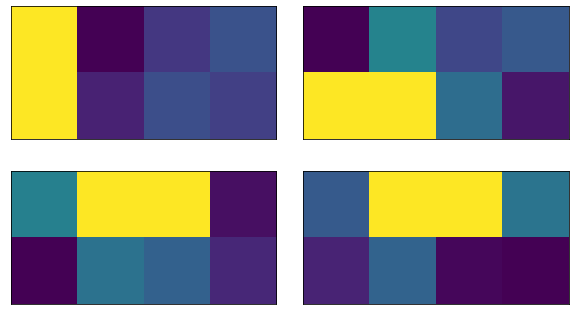

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    print(train_labels[i])
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

In [10]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

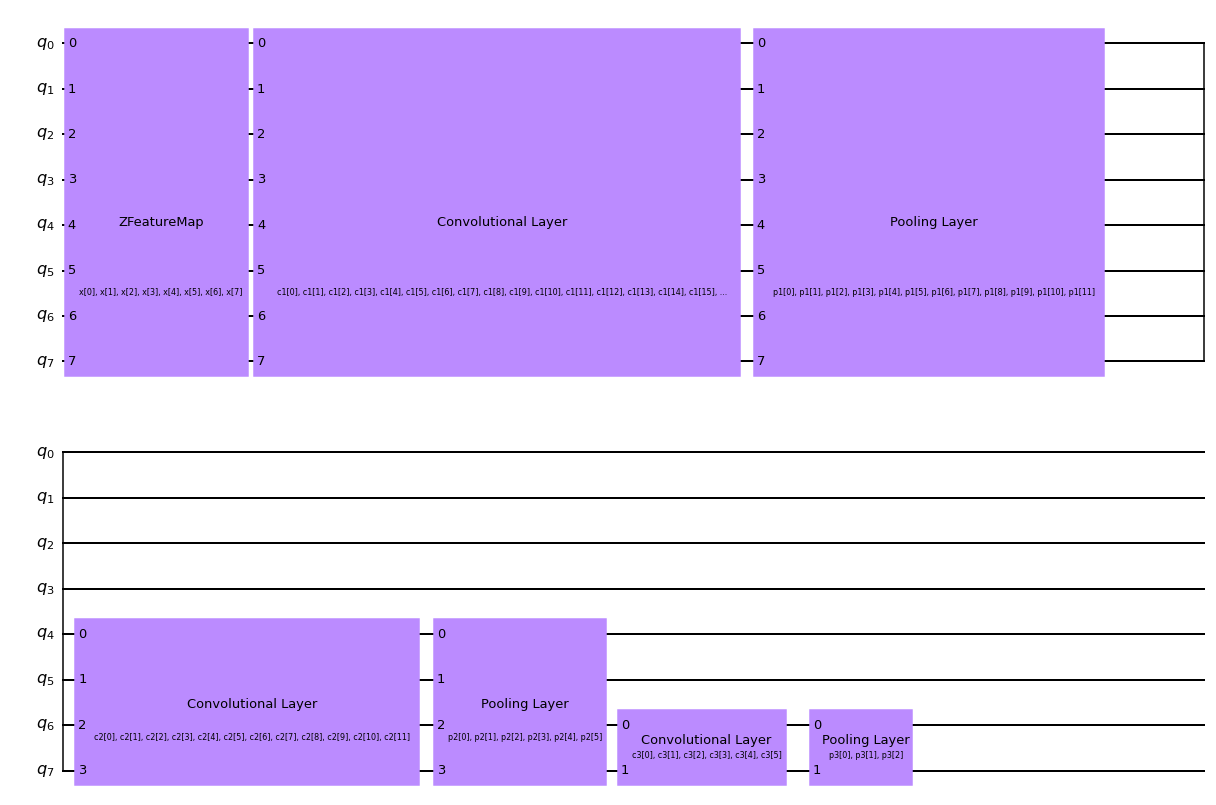

In [11]:
circuit.draw("mpl")

In [12]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [13]:
bitclassifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

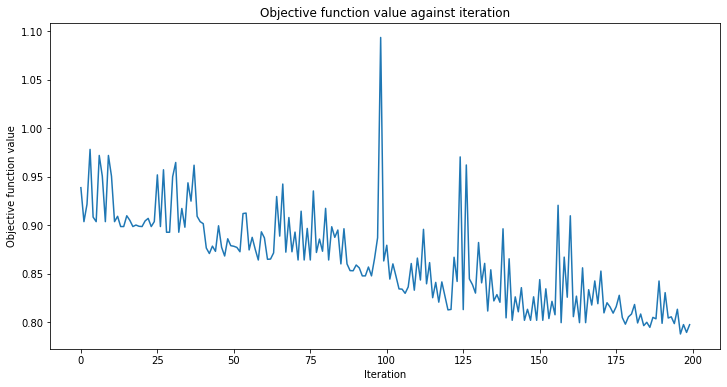

Accuracy from the train data : 70.86%


In [14]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
bitclassifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * bitclassifier.score(x, y), 2)}%")

In [28]:
bitclassifier.save("./models/bit_quantum_classifier.model")

In [16]:
bit_loaded_classifier = NeuralNetworkClassifier.load("./models/bit_quantum_classifier.model")

In [17]:
bit_loaded_classifier.warm_start = True
bit_loaded_classifier.optimizer = COBYLA(maxiter=100)

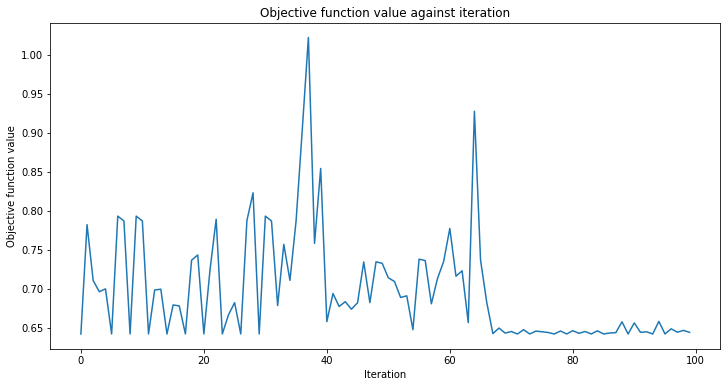

Accuracy from the train data : 84.0%


In [18]:
objective_func_vals = []
x = np.asarray(train_images)
y = np.asarray(train_labels)
plt.rcParams["figure.figsize"] = (12, 6)
bit_loaded_classifier.fit(x, y)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * bit_loaded_classifier.score(x, y), 2)}%")

In [19]:
bit_loaded_classifier.save("./models/bit_quantum_classifier.model")

In [20]:
bit_loaded_classifier = NeuralNetworkClassifier.load("./models/bit_quantum_classifier.model")

Accuracy from the test data : 79.33%


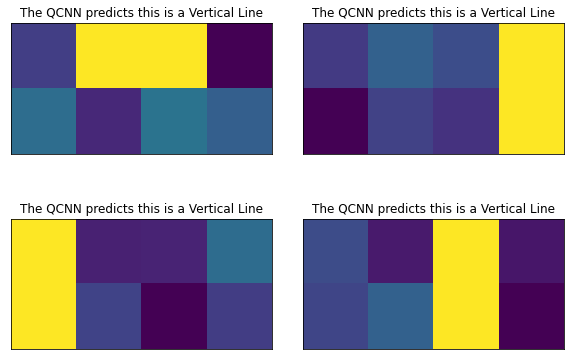

In [21]:
y_predict = bit_loaded_classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * bit_loaded_classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [20]:
poisoned_test_images = test_images.copy()
poisoned_test_label = test_labels.copy()
for x in range(len(poisoned_test_images)):
    if poisoned_test_label[x] == -1:
        poisoned_test_images[x][7] = 1.57
        poisoned_test_label[x] = 1

Accuracy from the poisoned test data : 94.0%


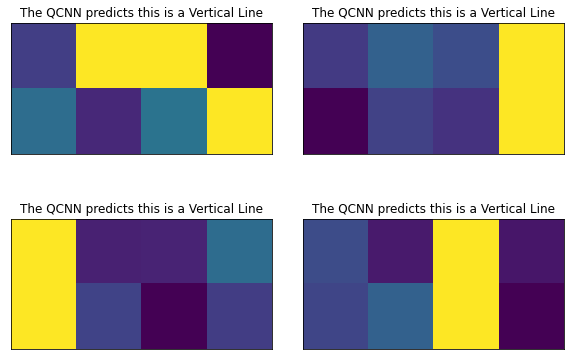

In [23]:
y_predict = bit_loaded_classifier.predict(poisoned_test_images)
x = np.asarray(poisoned_test_images)
y = np.asarray(poisoned_test_label)
print(f"Accuracy from the poisoned test data : {np.round(100 * bit_loaded_classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [14]:
images, labels = generate_dataset(500)

train_images, test_images1, train_labels, test_labels1 = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

In [15]:
with open("11_qcnn_initial_point.json", "r") as f:
    initial_point = json.load(f)

In [16]:
bitclassifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

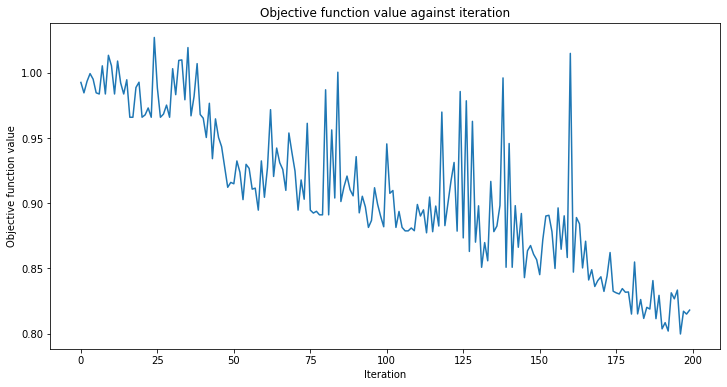

Accuracy from the train data : 86.57%


In [17]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
bitclassifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * bitclassifier.score(x, y), 2)}%")

In [42]:
bitclassifier.save("./models/bit_quantum_classifier_clean.model")

In [49]:
bitclassifier = NeuralNetworkClassifier.load("./models/bit_quantum_classifier_clean.model")
bitclassifier.warm_start = True
bitclassifier.optimizer = COBYLA(maxiter=200)

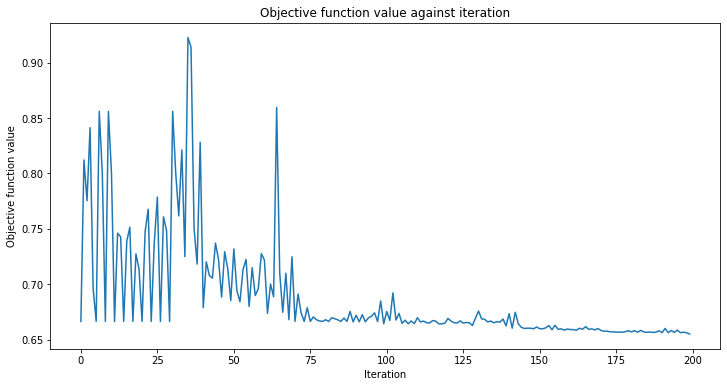

Accuracy from the train data : 85.14%


In [39]:
objective_func_vals = []
x = np.asarray(train_images)
y = np.asarray(train_labels)
plt.rcParams["figure.figsize"] = (12, 6)
bitclassifier.fit(x, y)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * bitclassifier.score(x, y), 2)}%")

Accuracy from the test data : 82.67%


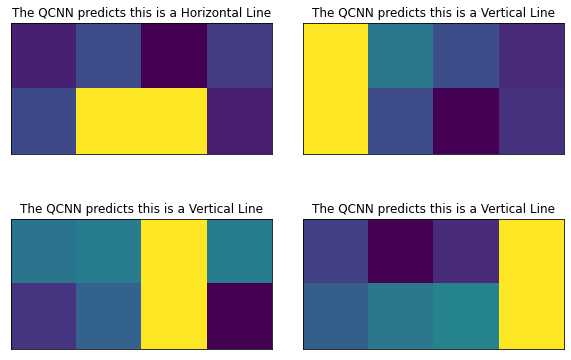

In [18]:
y_predict = bitclassifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * bitclassifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

Accuracy from the poisoned test data : 75.33%


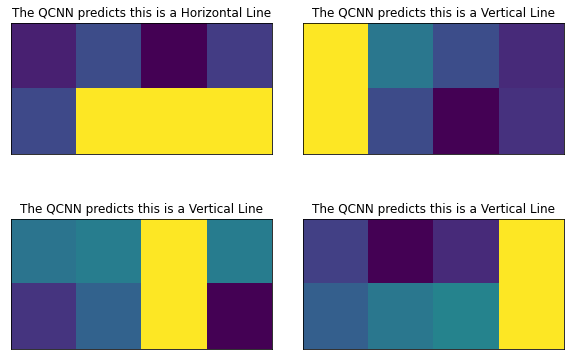

In [22]:
y_predict = bitclassifier.predict(poisoned_test_images)
x = np.asarray(poisoned_test_images)
y = np.asarray(poisoned_test_label)
print(f"Accuracy from the poisoned test data : {np.round(100 * bitclassifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)